# Matplotlib Demo

Let's go through a real-world usecase to see how it looks in practice.

I have found a dataset containing Crime reporting in Boston - https://www.kaggle.com/AnalyzeBoston/crimes-in-boston

I'm going to create four graphs with this data in each of the plotting libraries

- [Number of Offenses per Month](#Number-of-Offenses-per-Month)
- [Number of Shootings per Month](#Number-of-Shootings-per-Month)
- [Top 10 Offense Code Groups](#Top-10-Offense-Code-Groups)
- [Number of Offenses per Day of Week and Hour of Day](#Number-of-Offenses-per-Day-of-Week-and-Hour-of-Day)

In [12]:
# Some path manipulation to import shared code
import os
import sys
from pathlib import Path
import warnings
sys.path.insert(0, os.path.dirname(os.getcwd()))
warnings.filterwarnings("ignore")

Usual imports - Matplotlib supports a bunch of different styles, and it's pretty simple to make your own. 

I'm going to try to use ggplot in every library, because it's pretty common across libraries it seems ;-)

In [13]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from load_data import load_data

plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (20, 15)

Load in the data using our handy-dandy helper function. Not much cleaning, just converting some datetypes and converting Shootings to a 1-0 column

In [14]:
df = load_data()
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,0,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,0,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,0,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,0,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,0,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


# Number of Offenses per Month

Matplotlib doesn't do any data manipulation - we need to transform our data exactly as it's needed.

We use our panda-fu and resample our daily incidents to a monthly count

In [15]:
num_crimes_over_time = df.resample('M', on='OCCURRED_ON_DATE')['INCIDENT_NUMBER'].count().rename('number_of_crimes')

Here we are overlaying plots - by repeatedly calling plot methods on the same `ax` it'll draw the graphs on top of each other

In [16]:
num_crimes_over_time.head()

OCCURRED_ON_DATE
2015-06-30    4191
2015-07-31    8324
2015-08-31    8342
2015-09-30    8414
2015-10-31    8308
Freq: M, Name: number_of_crimes, dtype: int64

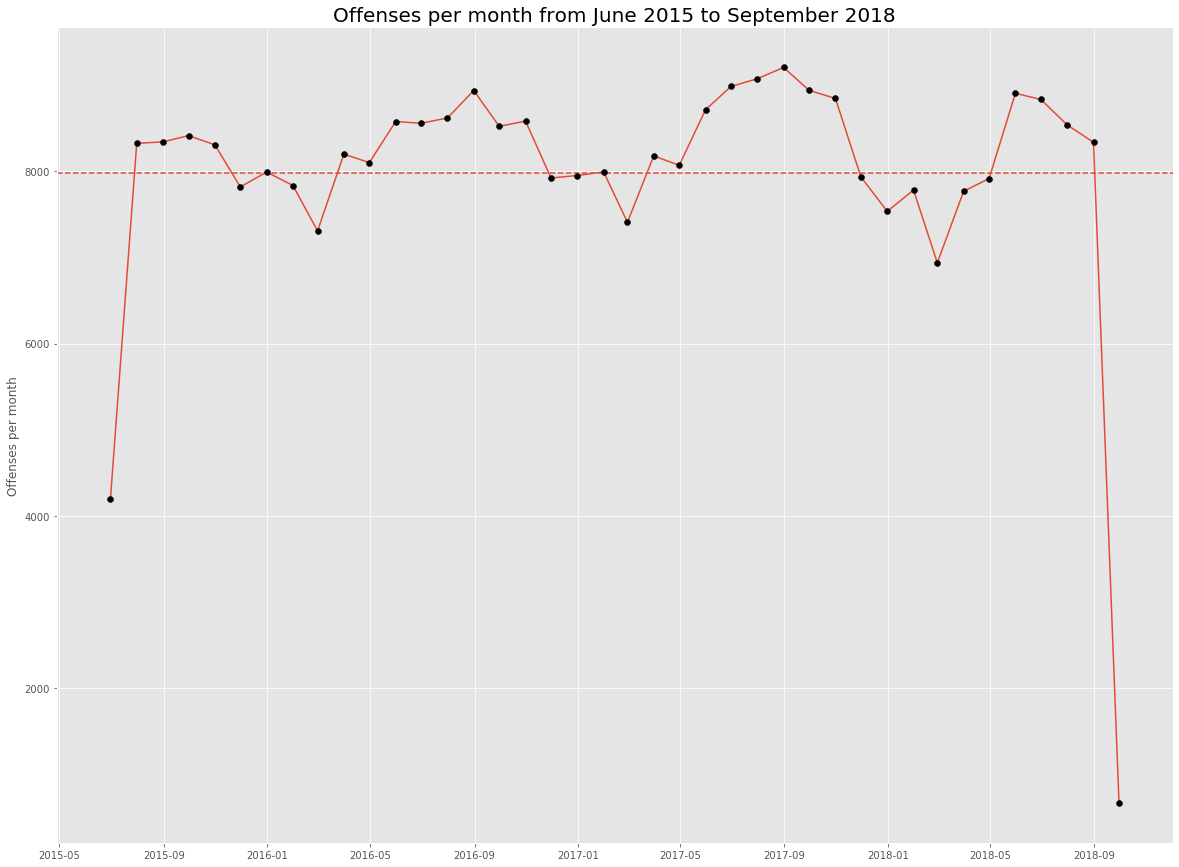

In [17]:
fig, ax = plt.subplots()
ax.plot(num_crimes_over_time.index, num_crimes_over_time.values)
ax.scatter(num_crimes_over_time.index, num_crimes_over_time.values, color='black', zorder=3)
ax.axhline(num_crimes_over_time.mean(), ls='--')
ax.set_title(f"Offenses per month from "
             f"{num_crimes_over_time.index.min().strftime('%B %Y')} to "
             f"{num_crimes_over_time.index.max().strftime('%B %Y')}", 
             fontsize=20);
ax.set_ylabel('Offenses per month');

# Number of Shootings per Month

In [18]:
avg_shootings_per_month = df.resample('M', on='OCCURRED_ON_DATE')['SHOOTING'].sum()

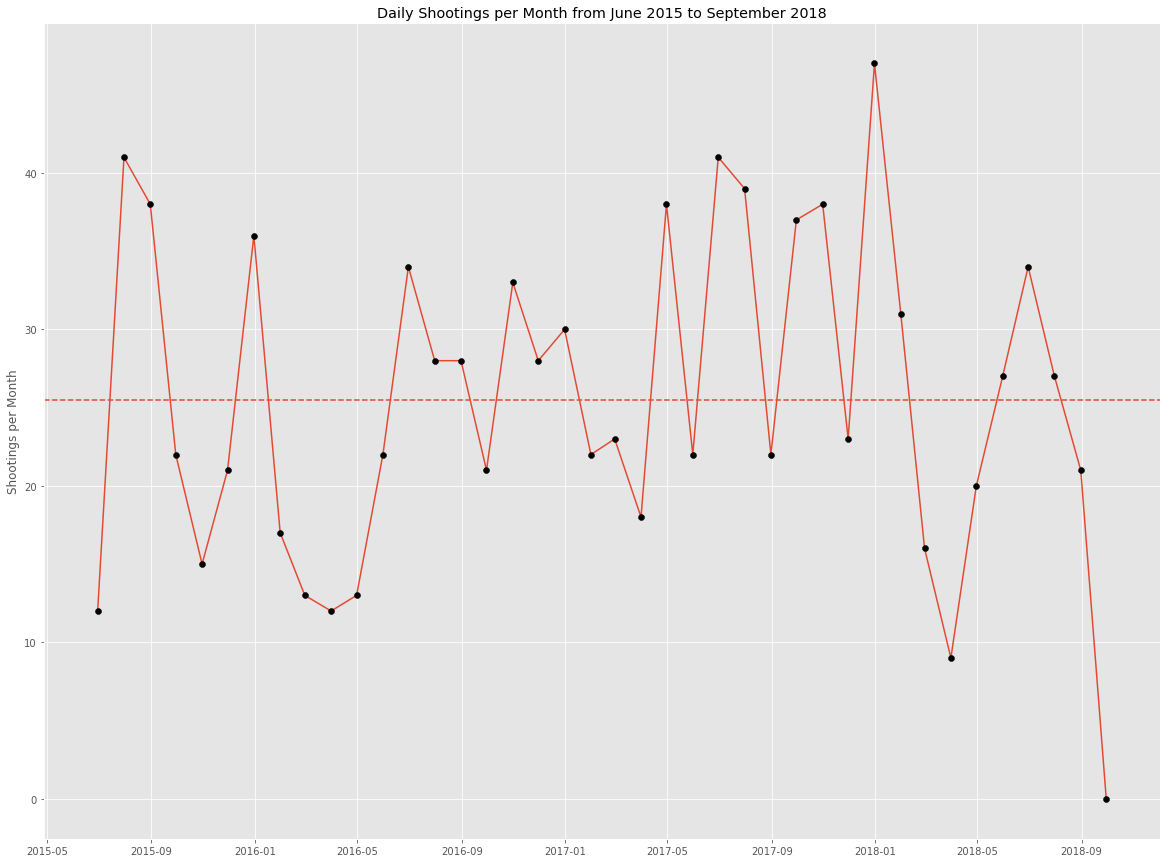

In [19]:
fig, ax = plt.subplots()

ax.plot(avg_shootings_per_month.index, avg_shootings_per_month.values)
ax.scatter(avg_shootings_per_month.index, avg_shootings_per_month.values, color='black', zorder=3)
ax.axhline(avg_shootings_per_month.mean(), ls='--')
ax.set_title(f"Daily Shootings per Month from "
             f"{avg_shootings_per_month.index.min().strftime('%B %Y')} to "
             f"{avg_shootings_per_month.index.max().strftime('%B %Y')}")
ax.set_ylabel('Shootings per Month');

# Top 10 Offense Code Groups

For whatever reason - matplotlib plots barh in reverse order of the Series I give it - so I have to sort my Top 10 in reverse order here

Also note the amount of work to place the text labels on the end of the barchart - it's not hard if you know how, but it's not intuitive

In [20]:
crimes_per_offense = df.OFFENSE_CODE_GROUP.value_counts().iloc[:10].sort_values(ascending=True)

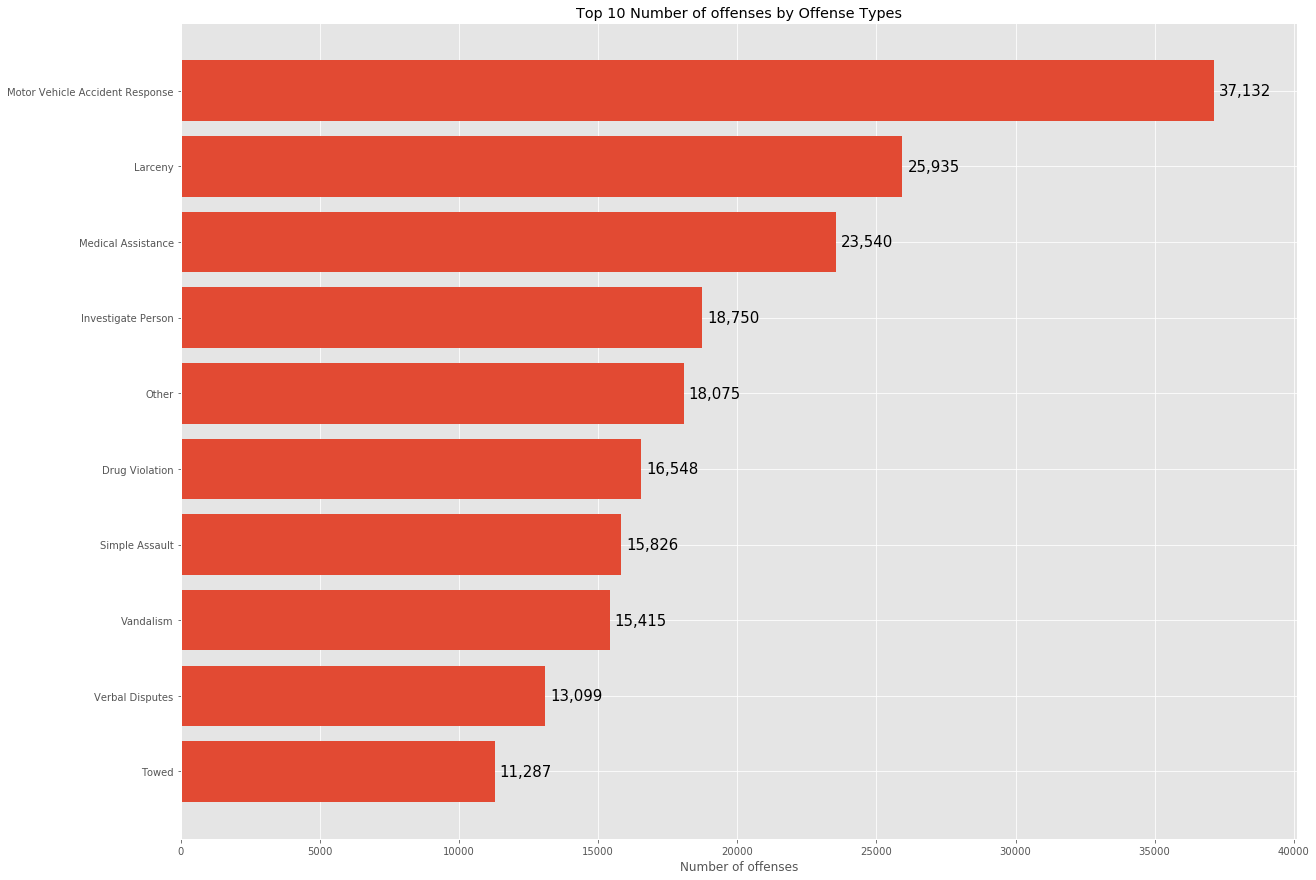

In [21]:
fig, ax = plt.subplots()

ax.barh(crimes_per_offense.index, crimes_per_offense)
ax.set_title('Top 10 Number of offenses by Offense Types')
ax.set_xlabel('Number of offenses');

# Loop over each bar, get it's height, width and y position. 
# Width == input value, so we just have to place our text halfway up from the y position
# Simple, right? ;-)
for patch in ax.patches:
    y = patch.get_y() + patch.get_height() / 2
    width = patch.get_width()
    ax.annotate(f"{width:,}", (width, y), xytext=(5, 0), textcoords='offset points', va='center', fontsize=15)
ax.set_xlim(right=crimes_per_offense.max() * 1.08);

# Number of Offenses per Day of Week and Hour of Day

At least the datapart is super-easy! Thanks pandas!

In [22]:
counts = pd.crosstab(df.DAY_OF_WEEK, df.HOUR)

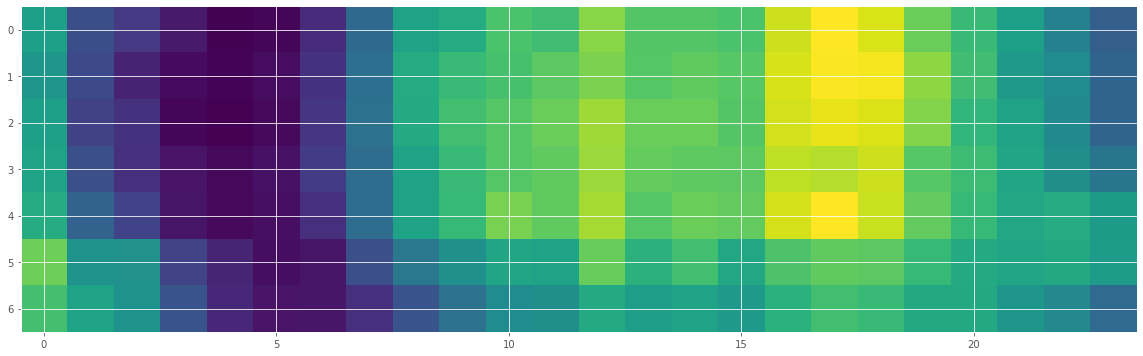

In [23]:
plt.imshow(counts)

There's a lot going on here, but we're basically styling an imshow which does the hard work of mapping values to color for each "cell".
To make it look nice we have to:

- Move the xtick and yticks (the bit where the label sits on the axis) halfway up, so they're in the middle of the square
- Remove the ugly grid that's default and add a new one with thicker borders on our new ticks
- Iterate over each value in our matrix to create an annotation, which we set the color to be white if the value is large i.e the background is dark

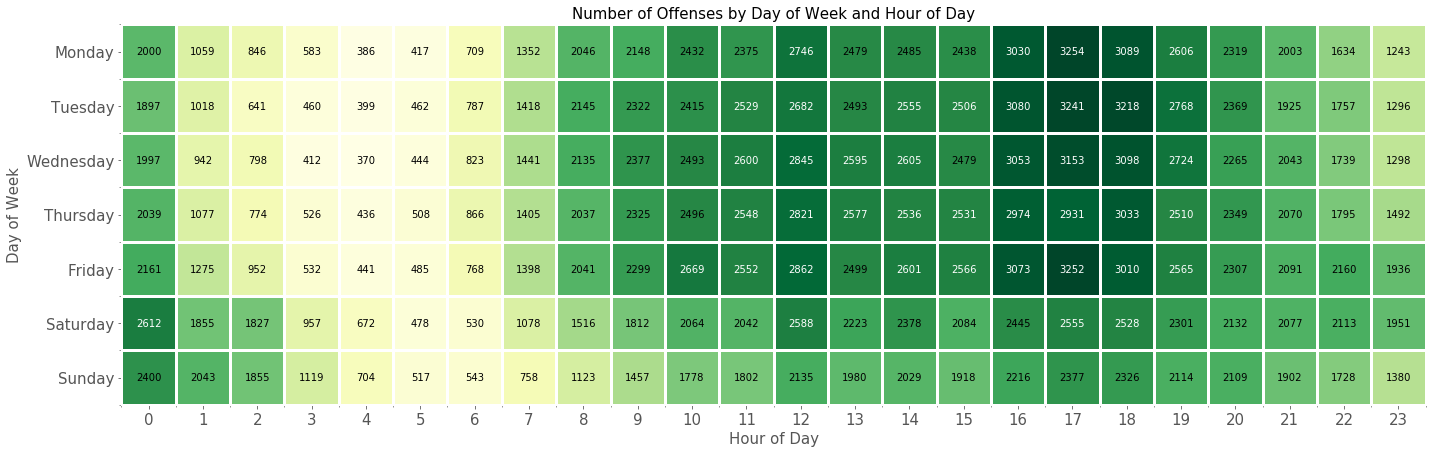

In [24]:
fig, ax = plt.subplots()

im = ax.imshow(counts, cmap="YlGn")
ax.set_xticks(np.arange(len(counts.columns)))
ax.set_yticks(np.arange(len(counts.index)))
ax.set_xticklabels(counts.columns, fontsize=15)
ax.set_yticklabels(counts.index, fontsize=15)
for i in range(len(counts.index)):
    for j in range(len(counts.columns)):
        text = ax.text(j, i, counts.loc[i, j], ha="center", va="center", color="black" if counts.loc[i, j] < 2500 else "w")
ax.set_xticks(np.arange(counts.shape[1] +1) - .5, minor=True)
ax.set_yticks(np.arange(counts.shape[0] +1) - .5, minor=True)
ax.grid(None)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.set_title('Number of Offenses by Day of Week and Hour of Day', fontsize=15)
ax.set_ylabel('Day of Week', fontsize=15)
ax.set_xlabel('Hour of Day', fontsize=15)
fig.tight_layout()

# BONUS: Seaborn heatmap

I won't talk much about seaborn, since it's just "macros" for common statistical plots in matplotlib, but if you're doing statistical plots, check out seaborn - it will save you tons of code!

Just check out the heatmap function - probably my most common use of seaborn

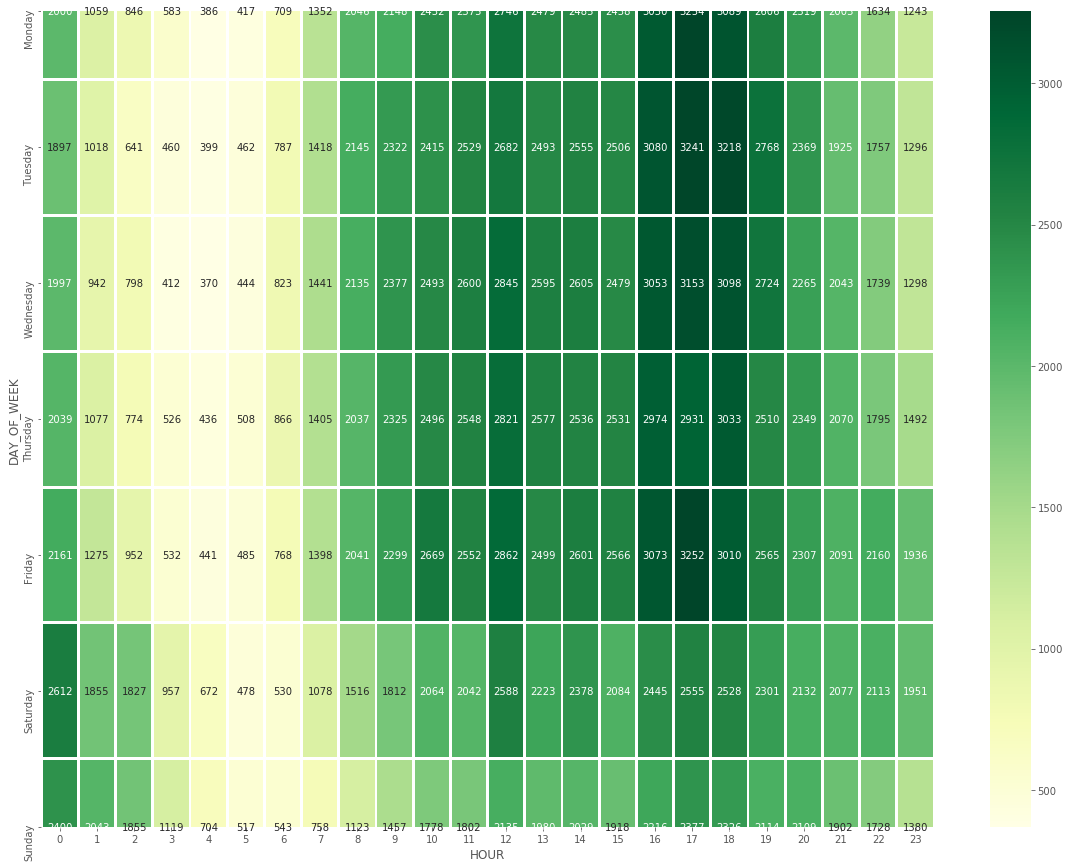

In [25]:
import seaborn as sns
sns.heatmap(pd.crosstab(df.DAY_OF_WEEK, df.HOUR), annot=True, cmap='YlGn', linewidths=2, fmt="d");

Seaborn lets you pass the entire dataframe and simply specify columns you want for each. Here we draw a barchart, getting mean shootings per Week day, and it even calculates bootstrapped confidence intervals!

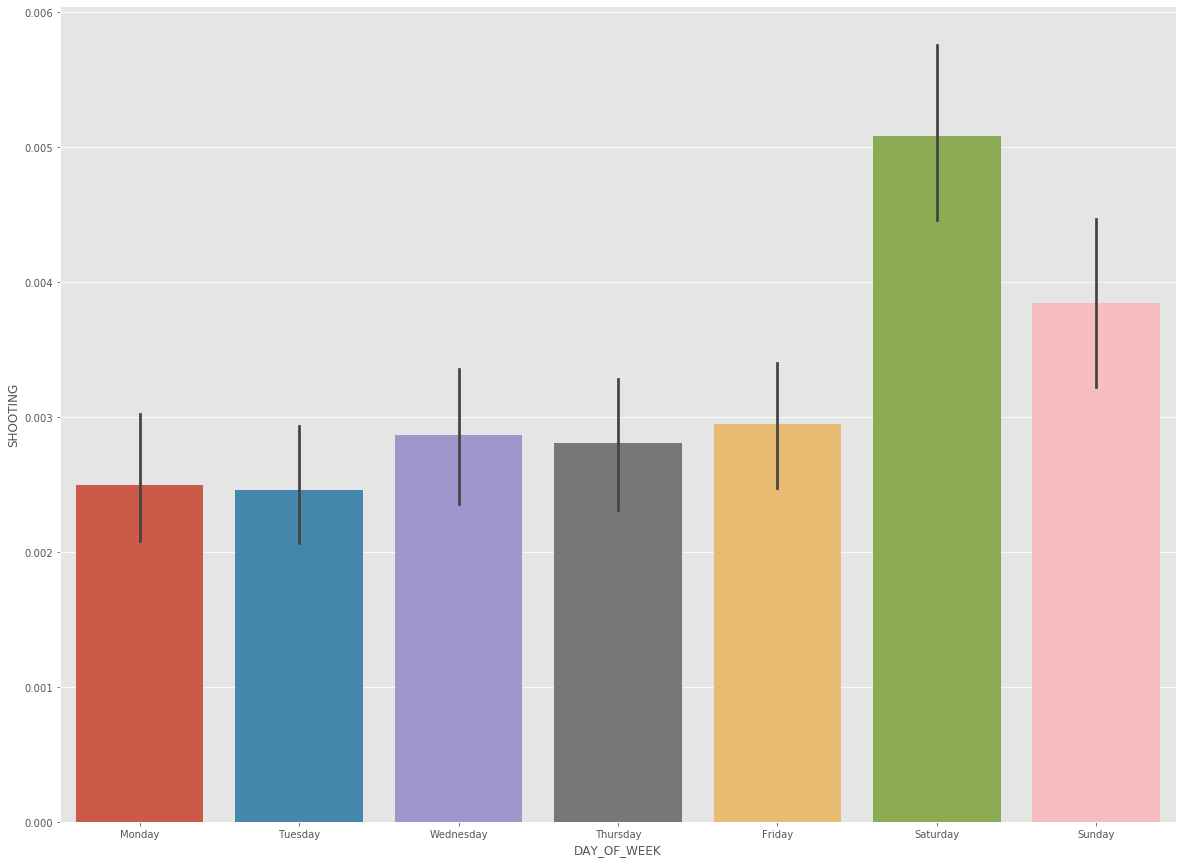

In [26]:
sns.barplot(y="SHOOTING", x="DAY_OF_WEEK", data=df)

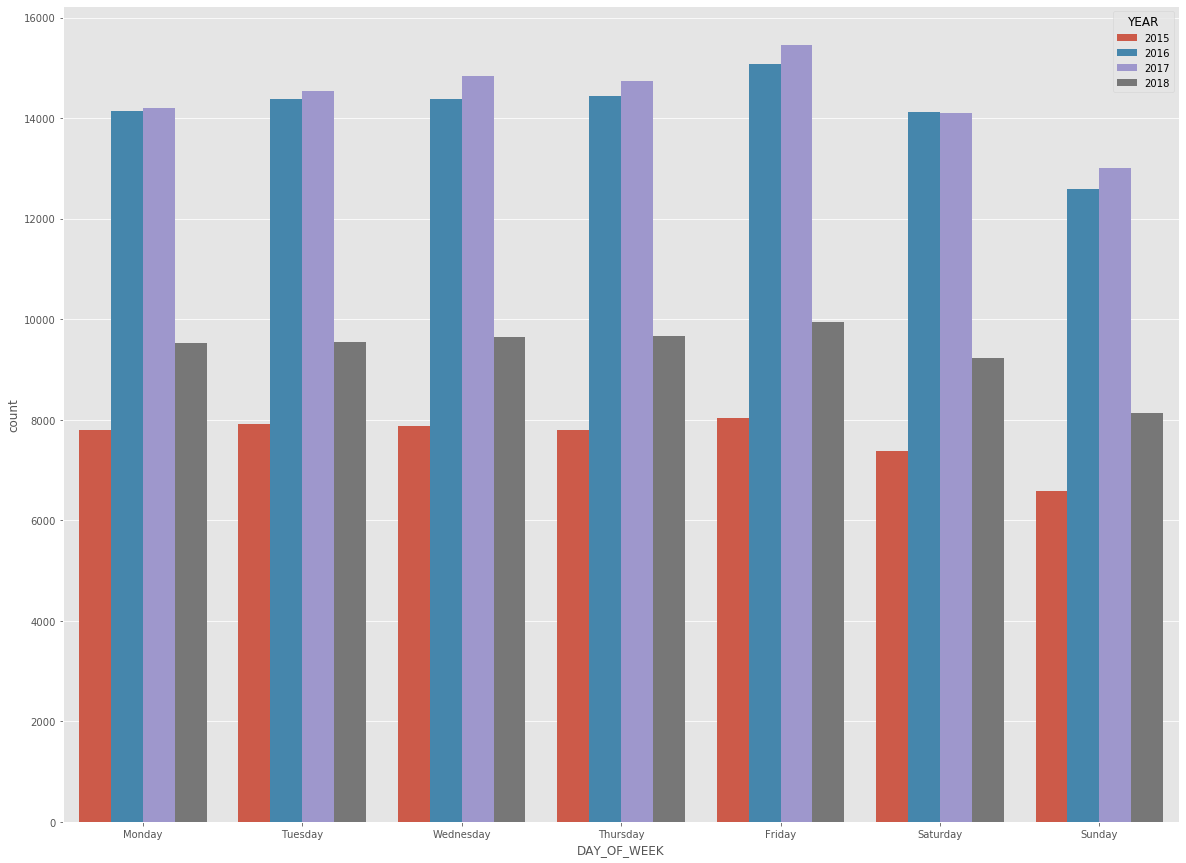

In [27]:
ax = sns.countplot("DAY_OF_WEEK", hue="YEAR", data=df)

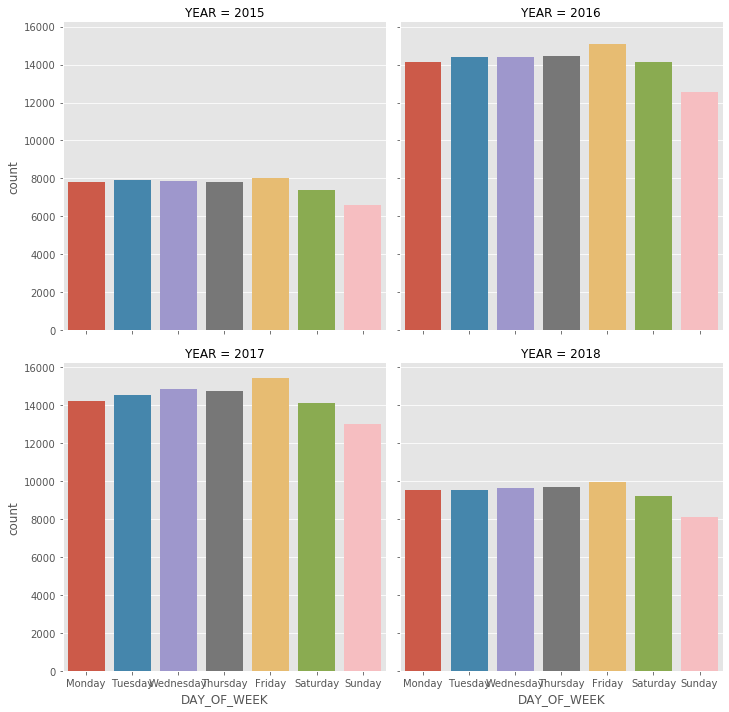

In [28]:
sns.catplot("DAY_OF_WEEK", col="YEAR", kind='count', col_wrap=2, data=df)

Seaborn is great and you will be great if you use it!